In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import yaml
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, AutoEmbeddingComposite
from dwave.samplers import SimulatedAnnealingSampler
from dwave_networkx.algorithms.coloring import min_vertex_color, is_vertex_coloring
import time
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
from graphilp.partitioning import min_vertex_coloring as vtx
from graphilp.imports import networkx as imp_nx

In [262]:
#q_sampler = AutoEmbeddingComposite(DWaveSampler(token='DEV-076b8a03c140ad9291e859ef02ab3403afc91429'))

#### Generate Network 

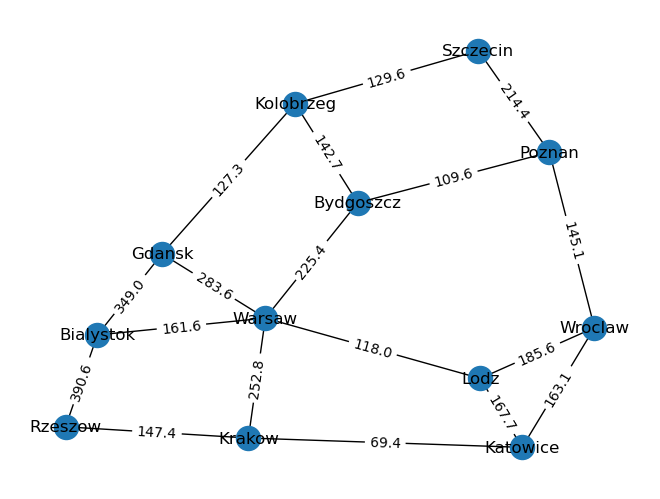

In [5]:
def plot_graph(filename):

    G = nx.read_weighted_edgelist(filename)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()
    return G
G=plot_graph("networks/poland.txt")

#### Generate Network Demands

In [167]:
def generate_demands(G):
    demands = {}
    for a in G.nodes:
        for b in G.nodes:
            if b == a:
                pass
            else:
                x = random.randrange(0, 3, 1)
                if x == 0:
                    demands[(a, b)] = 10
                elif x == 1:
                    demands[(a, b)] = 40
                else:
                    demands[(a, b)] = 100
    return demands
#demands={('a', 'b'): 40, ('a', 'c'): 10, ('a', 'd'): 100, ('b', 'a'): 10, ('b', 'c'): 100, ('b', 'd'): 100, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'd'): 100, ('d', 'a'): 100, ('d', 'b'): 10, ('d', 'c'): 100}
demands=generate_demands(G)
print(demands)
#4-demands={('a', 'b'): 40, ('a', 'e'): 40, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'a'): 10, ('b', 'e'): 40, ('b', 'c'): 40, ('b', 'd'): 10, ('e', 'a'): 100, ('e', 'b'): 100, ('e', 'c'): 40, ('e', 'd'): 100, ('c', 'a'): 10, ('c', 'b'): 100, ('c', 'e'): 40, ('c', 'd'): 100, ('d', 'a'): 10, ('d', 'b'): 100, ('d', 'e'): 100, ('d', 'c'): 10}
# demands={('a', 'b'): 40, ('a', 'e'): 100, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'a'): 10, ('b', 'e'): 100, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'a'): 10, ('e', 'b'): 10, ('e', 'c'): 40, ('e', 'd'): 40, ('c', 'a'): 100, ('c', 'b'): 100, ('c', 'e'): 100, ('c', 'd'): 40, ('d', 'a'): 10, ('d', 'b'): 40, ('d', 'e'): 10, ('d', 'c'): 10}
demands={('Gdansk', 'Warsaw'): 40, ('Gdansk', 'Kolobrzeg'): 100, ('Gdansk', 'Bydgoszcz'): 100, ('Gdansk', 'Poznan'): 40, ('Gdansk', 'Szczecin'): 100, ('Gdansk', 'Katowice'): 10, ('Gdansk', 'Krakow'): 10, ('Gdansk', 'Lodz'): 40, ('Gdansk', 'Wroclaw'): 10, ('Gdansk', 'Rzeszow'): 10, ('Gdansk', 'Bialystok'): 40, ('Warsaw', 'Gdansk'): 40, ('Warsaw', 'Kolobrzeg'): 100, ('Warsaw', 'Bydgoszcz'): 40, ('Warsaw', 'Poznan'): 100, ('Warsaw', 'Szczecin'): 10, ('Warsaw', 'Katowice'): 40, ('Warsaw', 'Krakow'): 10, ('Warsaw', 'Lodz'): 100, ('Warsaw', 'Wroclaw'): 10, ('Warsaw', 'Rzeszow'): 40, ('Warsaw', 'Bialystok'): 10, ('Kolobrzeg', 'Gdansk'): 10, ('Kolobrzeg', 'Warsaw'): 40, ('Kolobrzeg', 'Bydgoszcz'): 100, ('Kolobrzeg', 'Poznan'): 100, ('Kolobrzeg', 'Szczecin'): 100, ('Kolobrzeg', 'Katowice'): 40, ('Kolobrzeg', 'Krakow'): 100, ('Kolobrzeg', 'Lodz'): 40, ('Kolobrzeg', 'Wroclaw'): 40, ('Kolobrzeg', 'Rzeszow'): 100, ('Kolobrzeg', 'Bialystok'): 10, ('Bydgoszcz', 'Gdansk'): 40, ('Bydgoszcz', 'Warsaw'): 40, ('Bydgoszcz', 'Kolobrzeg'): 100, ('Bydgoszcz', 'Poznan'): 100, ('Bydgoszcz', 'Szczecin'): 40, ('Bydgoszcz', 'Katowice'): 10, ('Bydgoszcz', 'Krakow'): 40, ('Bydgoszcz', 'Lodz'): 100, ('Bydgoszcz', 'Wroclaw'): 40, ('Bydgoszcz', 'Rzeszow'): 100, ('Bydgoszcz', 'Bialystok'): 10, ('Poznan', 'Gdansk'): 10, ('Poznan', 'Warsaw'): 10, ('Poznan', 'Kolobrzeg'): 40, ('Poznan', 'Bydgoszcz'): 10, ('Poznan', 'Szczecin'): 100, ('Poznan', 'Katowice'): 100, ('Poznan', 'Krakow'): 10, ('Poznan', 'Lodz'): 10, ('Poznan', 'Wroclaw'): 40, ('Poznan', 'Rzeszow'): 100, ('Poznan', 'Bialystok'): 100, ('Szczecin', 'Gdansk'): 40, ('Szczecin', 'Warsaw'): 100, ('Szczecin', 'Kolobrzeg'): 10, ('Szczecin', 'Bydgoszcz'): 100, ('Szczecin', 'Poznan'): 100, ('Szczecin', 'Katowice'): 10, ('Szczecin', 'Krakow'): 40, ('Szczecin', 'Lodz'): 40, ('Szczecin', 'Wroclaw'): 100, ('Szczecin', 'Rzeszow'): 40, ('Szczecin', 'Bialystok'): 40, ('Katowice', 'Gdansk'): 40, ('Katowice', 'Warsaw'): 10, ('Katowice', 'Kolobrzeg'): 40, ('Katowice', 'Bydgoszcz'): 40, ('Katowice', 'Poznan'): 100, ('Katowice', 'Szczecin'): 10, ('Katowice', 'Krakow'): 40, ('Katowice', 'Lodz'): 10, ('Katowice', 'Wroclaw'): 100, ('Katowice', 'Rzeszow'): 40, ('Katowice', 'Bialystok'): 100, ('Krakow', 'Gdansk'): 10, ('Krakow', 'Warsaw'): 40, ('Krakow', 'Kolobrzeg'): 10, ('Krakow', 'Bydgoszcz'): 40, ('Krakow', 'Poznan'): 40, ('Krakow', 'Szczecin'): 10, ('Krakow', 'Katowice'): 10, ('Krakow', 'Lodz'): 10, ('Krakow', 'Wroclaw'): 40, ('Krakow', 'Rzeszow'): 40, ('Krakow', 'Bialystok'): 100, ('Lodz', 'Gdansk'): 40, ('Lodz', 'Warsaw'): 10, ('Lodz', 'Kolobrzeg'): 40, ('Lodz', 'Bydgoszcz'): 100, ('Lodz', 'Poznan'): 10, ('Lodz', 'Szczecin'): 100, ('Lodz', 'Katowice'): 100, ('Lodz', 'Krakow'): 10, ('Lodz', 'Wroclaw'): 10, ('Lodz', 'Rzeszow'): 40, ('Lodz', 'Bialystok'): 10, ('Wroclaw', 'Gdansk'): 40, ('Wroclaw', 'Warsaw'): 100, ('Wroclaw', 'Kolobrzeg'): 100, ('Wroclaw', 'Bydgoszcz'): 10, ('Wroclaw', 'Poznan'): 10, ('Wroclaw', 'Szczecin'): 10, ('Wroclaw', 'Katowice'): 100, ('Wroclaw', 'Krakow'): 40, ('Wroclaw', 'Lodz'): 40, ('Wroclaw', 'Rzeszow'): 40, ('Wroclaw', 'Bialystok'): 10, ('Rzeszow', 'Gdansk'): 10, ('Rzeszow', 'Warsaw'): 100, ('Rzeszow', 'Kolobrzeg'): 100, ('Rzeszow', 'Bydgoszcz'): 100, ('Rzeszow', 'Poznan'): 10, ('Rzeszow', 'Szczecin'): 100, ('Rzeszow', 'Katowice'): 10, ('Rzeszow', 'Krakow'): 40, ('Rzeszow', 'Lodz'): 40, ('Rzeszow', 'Wroclaw'): 10, ('Rzeszow', 'Bialystok'): 100, ('Bialystok', 'Gdansk'): 100, ('Bialystok', 'Warsaw'): 100, ('Bialystok', 'Kolobrzeg'): 100, ('Bialystok', 'Bydgoszcz'): 100, ('Bialystok', 'Poznan'): 40, ('Bialystok', 'Szczecin'): 10, ('Bialystok', 'Katowice'): 100, ('Bialystok', 'Krakow'): 10, ('Bialystok', 'Lodz'): 100, ('Bialystok', 'Wroclaw'): 10, ('Bialystok', 'Rzeszow'): 10}


{('Gdansk', 'Warsaw'): 100, ('Gdansk', 'Kolobrzeg'): 40, ('Gdansk', 'Bydgoszcz'): 10, ('Gdansk', 'Poznan'): 10, ('Gdansk', 'Szczecin'): 100, ('Gdansk', 'Katowice'): 100, ('Gdansk', 'Krakow'): 40, ('Gdansk', 'Lodz'): 40, ('Gdansk', 'Wroclaw'): 100, ('Gdansk', 'Rzeszow'): 10, ('Gdansk', 'Bialystok'): 40, ('Warsaw', 'Gdansk'): 100, ('Warsaw', 'Kolobrzeg'): 100, ('Warsaw', 'Bydgoszcz'): 40, ('Warsaw', 'Poznan'): 40, ('Warsaw', 'Szczecin'): 10, ('Warsaw', 'Katowice'): 40, ('Warsaw', 'Krakow'): 100, ('Warsaw', 'Lodz'): 40, ('Warsaw', 'Wroclaw'): 40, ('Warsaw', 'Rzeszow'): 10, ('Warsaw', 'Bialystok'): 10, ('Kolobrzeg', 'Gdansk'): 40, ('Kolobrzeg', 'Warsaw'): 40, ('Kolobrzeg', 'Bydgoszcz'): 40, ('Kolobrzeg', 'Poznan'): 100, ('Kolobrzeg', 'Szczecin'): 10, ('Kolobrzeg', 'Katowice'): 40, ('Kolobrzeg', 'Krakow'): 40, ('Kolobrzeg', 'Lodz'): 100, ('Kolobrzeg', 'Wroclaw'): 100, ('Kolobrzeg', 'Rzeszow'): 40, ('Kolobrzeg', 'Bialystok'): 40, ('Bydgoszcz', 'Gdansk'): 10, ('Bydgoszcz', 'Warsaw'): 10, ('By

In [265]:
#demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'a'): 40, ('b', 'e'): 10, ('b', 'f'): 40, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'a'): 100, ('e', 'b'): 100, ('e', 'f'): 100, ('e', 'c'): 40, ('e', 'd'): 100, ('f', 'a'): 100, ('f', 'b'): 40, ('f', 'e'): 100, ('f', 'c'): 10, ('f', 'd'): 100, ('c', 'a'): 40, ('c', 'b'): 100, ('c', 'e'): 100, ('c', 'f'): 100, ('c', 'd'): 40, ('d', 'a'): 40, ('d', 'b'): 100, ('d', 'e'): 100, ('d', 'f'): 10, ('d', 'c'): 40}
cropped_demands={}
for item in demands:
    if item[1]>item[0]:
        cropped_demands[item]=demands[item]
print(cropped_demands)
#1-demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'e'): 40, ('b', 'f'): 40, ('b', 'c'): 10, ('b', 'd'): 10, ('e', 'f'): 10, ('c', 'e'): 10, ('c', 'f'): 100, ('c', 'd'): 100, ('d', 'e'): 100, ('d', 'f'): 40}
#2-demands={('a', 'b'): 10, ('a', 'e'): 10, ('a', 'f'): 10, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'e'): 10, ('b', 'f'): 40, ('b', 'c'): 100, ('b', 'd'): 40, ('e', 'f'): 100, ('c', 'e'): 100, ('c', 'f'): 100, ('c', 'd'): 40, ('d', 'e'): 100, ('d', 'f'): 10}
#3-demands={('a', 'b'): 40, ('a', 'e'): 40, ('a', 'f'): 40, ('a', 'c'): 10, ('a', 'd'): 10, ('b', 'e'): 100, ('b', 'f'): 100, ('b', 'c'): 10, ('b', 'd'): 10, ('e', 'f'): 10, ('c', 'e'): 10, ('c', 'f'): 40, ('c', 'd'): 10, ('d', 'e'): 10, ('d', 'f'): 100}

{('a', 'b'): 40, ('a', 'e'): 100, ('a', 'c'): 100, ('a', 'd'): 40, ('b', 'e'): 100, ('b', 'c'): 100, ('b', 'd'): 40, ('c', 'e'): 100, ('c', 'd'): 40, ('d', 'e'): 10}


#### Generate transformed graph

462
76068


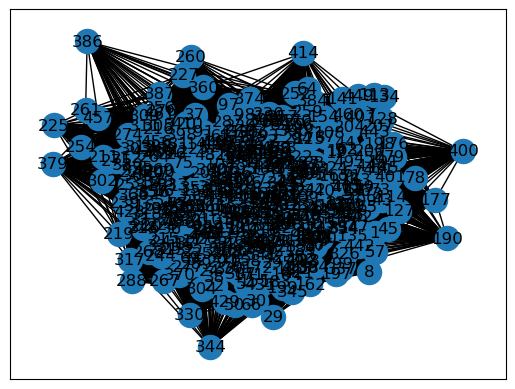

In [168]:
def create_graph(filepath, Graph, demands):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    converted_graph = nx.Graph()
    s_d_label = 0
    label = 0
    for a in network_data:
        s_d_label += 1
        source = network_data[a]["source"]
        destination = network_data[a]["destination"]
        rate = demands[(source, destination)]
        for i in network_data[a]["routes"]:
            label += 1
            nodes_in_path = i
            edges_in_path = []
            total_weight = 0
            for j in range(len(i) - 1):
                edges_in_path.append((nodes_in_path[j], nodes_in_path[j + 1]))
                edges_in_path.append((nodes_in_path[j+1], nodes_in_path[j])) # remove if direction of light matters.
                total_weight += Graph[nodes_in_path[j]][nodes_in_path[j + 1]]["weight"]
            converted_graph.add_node(label, s_d=s_d_label, r=rate,w=total_weight,edges=edges_in_path)
    x=converted_graph.number_of_nodes()
    for a in range(1,x):
        for b in range(a+1,x+1):
            if converted_graph.nodes[a]["s_d"] != converted_graph.nodes[b]["s_d"]: # don't want connection between same routes- then each one affects the others selection
                for j in converted_graph.nodes[a]["edges"]:
                    for i in converted_graph.nodes[b]["edges"]:
                        if i == j:
                            converted_graph.add_edge(a,b)
                            break
                    else:
                        continue
                    break
                        
                        
    return converted_graph

new_graph=create_graph("networks/poland-conversion.yaml",G,demands)
nx.draw_networkx(new_graph)
number_of_nodes=len(new_graph.nodes)
print(number_of_nodes)
print(new_graph.number_of_edges())

In [267]:
print(nx.adjacency_matrix(new_graph).todense())

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [1 0 0 ... 1 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Write QUBO formualtion

In [172]:
def create_qubo(Graph,c1,c2,c3,c4):
    Q={}
    adj_matrix=nx.adjacency_matrix(Graph)
    dense_matrix=adj_matrix.todense()
    set_of_nodes=Graph._node
    for a in set_of_nodes:
        for b in set_of_nodes:
            if Graph.nodes[a]["s_d"]==Graph.nodes[b]["s_d"]:
                if a==b:
                    Q[(a,b)]=-c1
                else:
                    Q[(a,b)]=2*c1
            elif dense_matrix[a-1][b-1]==1:
                Q[(a,b)]=c2
            else:
                Q[(a,b)]=0
    
    for a in set_of_nodes:
        length=Graph.nodes[a]["w"]  
        Q[(a,a)]+=c4*length
        if Graph.nodes[a]["r"]==10:
            max_d=1680
        elif Graph.nodes[a]["r"]==40:
            max_d=1170
        else:
            max_d=1060
        if length>max_d:
            Q[(a,a)]+=c3


    return Q
            
QUBO = create_qubo(new_graph,4,0.05,4,0.0001)
bqm= BinaryQuadraticModel.from_qubo(QUBO)

#### Solve with Gurobi  

In [18]:
def solve_qubo_with_gurobi(Q):
    # Create a Gurobi model
    model = Model("QUBO")

    # Suppress Gurobi output
    model.setParam('OutputFlag', 0)

    # Extract variables from QUBO keys
    variables = set(i for i, j in Q.keys()).union(set(j for i, j in Q.keys()))

    # Add binary variables to the model
    x = {v: model.addVar(vtype=GRB.BINARY, name=f'x_{v}') for v in variables}

    # Add the QUBO objective function
    model.setObjective(
        quicksum(Q[i, j] * x[i] * x[j] for i, j in Q.keys()),
        GRB.MINIMIZE
    )
    # Measure the runtime
    start_time = time.time()
    model.optimize()
    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time


    # Extract the solution
    if model.status == GRB.OPTIMAL:
        solution = {v: int(x[v].x) for v in variables}
        objective_value = model.objVal
        return solution, objective_value,runtime
    else:
        return None, None
gurobi_sol=solve_qubo_with_gurobi(QUBO)
print(gurobi_sol)

Restricted license - for non-production use only - expires 2026-11-23


GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [270]:
gurobi_table=[]
for i in range(1,number_of_nodes+1):
    gurobi_table.append(gurobi_sol[0][i])
print(gurobi_table)


[1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]


#### Solve with QA/SA 

In [173]:
def solve_qubo(bqm,sampler=SimulatedAnnealingSampler(),num_runs=1):
    sampleset= sampler.sample(bqm,num_reads=num_runs,label= "Routing QUBO solving")
    return sampleset

result=solve_qubo(bqm)
print(result)
for variable in range(1,number_of_nodes+1):
    print(int(result.first.sample[variable]))

   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 462     energy num_oc.
0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0 ...   0 -204.53502       1
['BINARY', 1 rows, 1 samples, 462 variables]
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1

#### Check if solution is valid

In [174]:
def is_valid_solution(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=[]
    total_length=0
    for i in range(1,number_of_nodes+1):
        solution_results.append(int(result.first.sample[i]))
        if int(result.first.sample[i])==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]

def is_valid_solution_gurobi(result,filepath,Graph):
    with open(filepath, "r") as f:
        network_data = yaml.safe_load(f)
    number_of_routes=[]
    counter=0
    for s_d_pair in network_data:
        counter+=len(network_data[s_d_pair]["routes"])
        number_of_routes.append(counter)
    solution_results=result
    total_length=0
    for i in range(1,number_of_routes[-1]+1):
        if solution_results[i-1]==1:
            total_length+=Graph.nodes[i]["w"]
            if Graph.nodes[i]["r"]==10:
                if Graph.nodes[i]["w"] >1680:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
                    
            elif Graph.nodes[i]["r"]==40:
                if Graph.nodes[i]["w"] >1170:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]
            else:
                if Graph.nodes[i]["w"] >1060:
                    return [False,i,Graph.nodes[i]["r"],Graph.nodes[i]["w"]]

    counter=0
    for i in number_of_routes:
        total_selected_routes=0
        for a in range(counter,i):
            total_selected_routes+=solution_results[a]
        if total_selected_routes==1:
            pass
        else:
            return [False,i,total_selected_routes]
        counter=i
    return [True,total_length]
    
print(is_valid_solution(result,"networks/poland-conversion.yaml",new_graph))
#print(is_valid_solution_gurobi(gurobi_table,"networks/graph3-conversion.yaml",new_graph))


[True, 29649.799999999996]


#### Is solution same as Gurobi solution

In [110]:
solution_values=[]
for variable in range(1,number_of_nodes+1):
    solution_values.append(int(result.first.sample[variable]))
#print(solution_values==gurobi_table)
#for variable in range(1,number_of_nodes+1):
    #if not solution_values[variable-1]==gurobi_table[variable-1]:
       # print(variable)

#### Brute force parameter search

In [177]:
solve_rate=[]
min_colouring=[]
total_lengths=[]
for i in range(0,100):
    QUBO = create_qubo(new_graph,4,0.05,4,0.0001*i)
    bqm= BinaryQuadraticModel.from_qubo(QUBO)
    #correct_solution=gurobi_table
    runs=1
    solved_cases=0
    time_taken=0
    colour_dic_SA={}
    for i in range(runs):
        start=time.perf_counter()
        solution=solve_qubo(bqm)
        end=time.perf_counter()
        time_taken+=(end-start)
        solution_outcomes=[]
        for variable in range(1,number_of_nodes+1):
            solution_outcomes.append(solution.first.sample[variable])
        if is_valid_solution(solution,"networks/poland-conversion.yaml",new_graph)[0]:
            solved_cases+=1
            graph=new_graph.copy()
            total_length=0
            for i in range(number_of_nodes-1):
                if solution_outcomes[i]==0:
                    graph.remove_node(i+1)
                else:
                    total_length+=new_graph.nodes[i+1]["w"]
            coloured=solve_graph_coloring_networkx(graph)
            if coloured["num_colors"] in colour_dic_SA:
                colour_dic_SA[coloured["num_colors"]]+=1
            else:
                colour_dic_SA[coloured["num_colors"]]=1
    solve_rate.append(solved_cases/runs)
    if colour_dic_SA=={}:
        min_colouring.append(500)
    else:
        min_colouring.append(min(colour_dic_SA.keys()))
    total_lengths.append(total_length)
    

print(solve_rate)
print(min_colouring)
print(total_lengths)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[13, 14, 15, 15, 15, 15, 15, 14, 14, 13, 14, 13, 14, 13, 13, 15, 13, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


#### SA accuracy test

In [191]:
QUBO = create_qubo(new_graph,4,0.05,4,0.0015)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
#correct_solution=gurobi_table
runs=100
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic_SA={}
colour_dic_lengths_SA={}
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/poland-conversion.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        total_length=0
        for i in range(number_of_nodes-1):
            if solution_outcomes[i]==0:
                graph.remove_node(i+1)
            else:
                total_length+=new_graph.nodes[i+1]["w"]
        coloured=solve_graph_coloring_networkx(graph)
        if coloured["num_colors"] in colour_dic_lengths_SA:
            colour_dic_lengths_SA[coloured["num_colors"]].append(total_length)
        else:
            colour_dic_lengths_SA[coloured["num_colors"]]=[total_length]
        if coloured["num_colors"] in colour_dic_SA:
            colour_dic_SA[coloured["num_colors"]]+=1
        else:
            colour_dic_SA[coloured["num_colors"]]=1
    #if solution_outcomes==correct_solution:
        # optimal_solves+=1
    

print(solved_cases/runs,optimal_solves/runs,time_taken/runs,colour_dic_SA) 

0.94 0.0 0.32723620099714024 {14: 35, 15: 8, 13: 47, 12: 4}


In [ ]:
print(min(colour_dic_lengths_SA))

KeyError: 16

#### QA accuracy test

In [277]:
QUBO = create_qubo(new_graph,1.5,0,2,0)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
saved_solutions=[]
runs=100
solved_cases=0
time_taken=0
optimal_solves=0
colour_dic={}
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    saved_solutions.append(solution)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if is_valid_solution(solution,"networks/graph1-conversion.yaml",new_graph)[0]:
        solved_cases+=1
        graph=new_graph.copy()
        for i in range(number_of_nodes):
            if solution_outcomes[i]==0:
                graph.remove_node(i+1)
        coloured=solve_graph_coloring_networkx(graph)
        if coloured["num_colors"] in colour_dic:
            colour_dic[coloured["num_colors"]]+=1
        else:
            colour_dic[coloured["num_colors"]]=1 
    if solution_outcomes==correct_solution:
        optimal_solves+=1
    

print(solved_cases/runs,optimal_solves/runs,time_taken/runs,colour_dic) 

0.0 0.0 0.010670520002022385 {}


#### Generate reduced graph

66


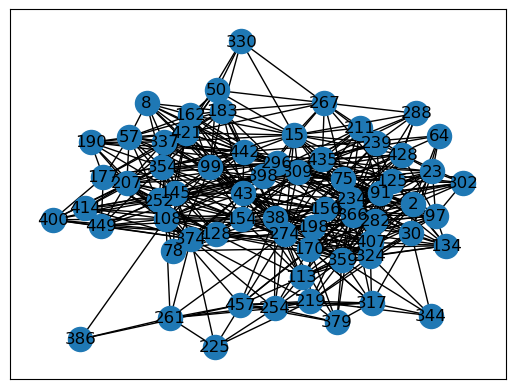

In [146]:
new_graph=create_graph("networks/poland-conversion.yaml",G,demands)
for i in range(number_of_nodes):
    if solution_values[i]==0:
        new_graph.remove_node(i+1)

pos = nx.spring_layout(G, k=100, iterations=100)
nx.draw_networkx(new_graph)
print(new_graph.number_of_nodes())

### Graph Colouring Gurobi

In [70]:
def solve_graph_coloring_gurobi(Graph):
    edges = list(Graph.edges)
    G = imp_nx.read(Graph)
    # List of edges (each edge represented as a tuple of nodes)
    

    # Create a Gurobi environment with output suppressed
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)  # Suppress output
    env.start()
    
    # Create the model using vtx.create_model
    mdl = vtx.create_model(G)

    # Optimize the model
    start_time = time.time()
    mdl.optimize()
    end_time = time.time()

    # Extract the solution using the provided function
    color_to_node, node_to_color = vtx.extract_solution(G, mdl)

    if mdl.status == GRB.OPTIMAL:
        # Use the extracted solution to build the color_map
        color_map = {node: color for color, nodes in color_to_node.items() for node in nodes}
        used_colors = set(color_map.values())

        # Verify that no two adjacent nodes have the same color
        valid = True
        for (i, j) in edges:
            if color_map[i] == color_map[j]:
                valid = False
                break  # No need to continue if an invalid pair is found

        return {
            "valid": valid,
            "num_colors": len(used_colors),
            "time_taken": end_time - start_time
        }
    else:
        return {
            "valid": False,
            "num_colors": None,
            "time_taken": end_time - start_time
        }

solve_graph_coloring_gurobi(new_graph)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 3 4300U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

### LDF Greedy

In [175]:
def solve_graph_coloring_networkx(G):
    start_time = time.time()
    nx_coloring = nx.coloring.greedy_color(G, strategy="largest_first")
    end_time = time.time()

    nx_colors_used = len(set(nx_coloring.values()))

    return {
        "valid": True,  # Greedy algorithm should provide a valid coloring
        "num_colors": nx_colors_used,
        "time_taken": end_time - start_time,
        "coloring": nx_coloring
    }
 
colouring=solve_graph_coloring_networkx(new_graph)
print(colouring)

{'valid': True, 'num_colors': 78, 'time_taken': 0.37551069259643555, 'coloring': {371: 0, 238: 1, 391: 2, 83: 3, 419: 4, 133: 5, 420: 4, 377: 6, 293: 7, 378: 6, 389: 2, 451: 8, 286: 9, 14: 10, 358: 11, 415: 4, 107: 12, 214: 13, 250: 14, 350: 15, 131: 5, 262: 16, 327: 17, 455: 8, 84: 3, 118: 18, 129: 5, 143: 19, 363: 11, 458: 20, 251: 14, 404: 21, 272: 22, 292: 7, 418: 4, 34: 23, 355: 24, 367: 0, 397: 25, 90: 26, 132: 5, 147: 19, 243: 27, 86: 26, 232: 1, 63: 28, 81: 3, 6: 29, 213: 13, 236: 1, 376: 6, 116: 18, 402: 21, 68: 30, 462: 20, 46: 31, 119: 18, 426: 32, 364: 11, 112: 12, 396: 25, 406: 21, 56: 33, 111: 12, 334: 34, 416: 4, 74: 35, 195: 36, 271: 22, 11: 10, 35: 23, 89: 26, 106: 12, 362: 11, 142: 19, 249: 14, 336: 34, 453: 8, 146: 19, 19: 37, 222: 38, 242: 27, 298: 39, 372: 6, 448: 40, 452: 8, 101: 41, 310: 42, 375: 6, 209: 43, 217: 13, 13: 10, 53: 33, 152: 44, 210: 43, 237: 1, 70: 30, 193: 36, 322: 45, 399: 25, 299: 39, 405: 21, 124: 46, 166: 47, 300: 39, 181: 48, 235: 1, 137: 49, 

#### QA to find colouring of generated graph

In [158]:
def solve_graph_coloring_annealing(G, sampler, attempts=30):
    start_time = time.time()
    for i in range(attempts):        
        solution = min_vertex_color(G, sampler=sampler, label="GCP")
        try:
            if is_vertex_coloring(G, solution):
                end_time = time.time()
                wavelengths = len(set(solution.values()))
                return {
                    "valid": True,
                    "num_colors": wavelengths,
                    "time_taken": end_time - start_time,
                    "solution": solution
                }
            print(f"[-] Attempt {i} failed")
        except KeyError:
            continue
    return "timeout"
colouring=solve_graph_coloring_annealing(new_graph,SimulatedAnnealingSampler())
print(colouring)

{'valid': True, 'num_colors': 16, 'time_taken': 0.2664196491241455, 'solution': {2: 9, 8: 4, 15: 2, 23: 3, 30: 1, 38: 6, 43: 1, 50: 1, 57: 2, 64: 12, 75: 7, 78: 4, 91: 8, 97: 2, 99: 14, 108: 8, 113: 2, 125: 1, 128: 9, 134: 10, 145: 11, 154: 10, 156: 6, 162: 8, 170: 3, 177: 16, 183: 9, 190: 6, 198: 13, 207: 1, 211: 9, 219: 4, 225: 0, 234: 11, 239: 4, 252: 5, 254: 9, 261: 10, 267: 7, 274: 5, 282: 4, 288: 8, 296: 10, 302: 9, 309: 12, 317: 8, 324: 12, 330: 10, 337: 0, 344: 0, 354: 7, 359: 14, 366: 5, 374: 2, 379: 0, 386: 0, 398: 13, 400: 10, 407: 0, 414: 0, 421: 3, 428: 0, 435: 3, 442: 5, 449: 6, 457: 7}}


#### Generate graph of colouring of reduced graph

13


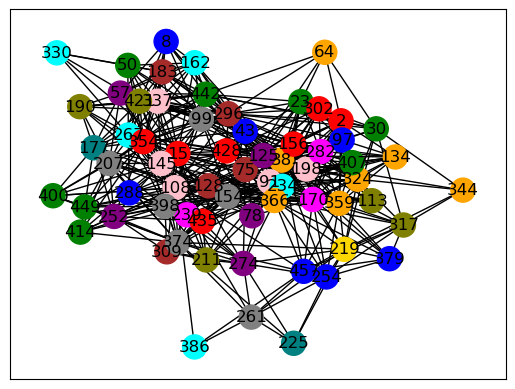

In [166]:
selected_colours=colouring["coloring"]
colours = [
    "red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan",
    "magenta", "teal", "gold", "navy", "lime", "maroon", "coral", "turquoise", "indigo", "salmon",
    "darkgreen", "deepskyblue", "chocolate", "orchid", "slateblue", "darkorange", "skyblue", "firebrick", "mediumseagreen", "dodgerblue",
    "plum", "lightcoral", "mediumvioletred", "sienna", "khaki", "darkcyan", "steelblue", "crimson", "darkorchid", "mediumturquoise"
]
color_map=[]
for a in selected_colours:
    color_map.append(colours[selected_colours[a]])
print(colouring["num_colors"])
pos = nx.spring_layout(G, k=100, iterations=100)
nx.draw_networkx(new_graph,node_color=color_map)

#### SA accuracy test

In [ ]:
QUBO = create_qubo(new_graph,1,0.01,3.5)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
runs=10
solved_cases=0
time_taken=0
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if solution_outcomes==correct_solution:
        solved_cases+=1

print(solved_cases/runs,time_taken/runs)   

#### QA accuracy test

In [ ]:
QUBO = create_qubo(new_graph,1,0.01,3.5)
bqm= BinaryQuadraticModel.from_qubo(QUBO)
correct_solution=gurobi_table
runs=10
solved_cases=0
time_taken=0
for i in range(runs):
    start=time.perf_counter()
    solution=solve_qubo(bqm,q_sampler)
    end=time.perf_counter()
    time_taken+=(end-start)
    solution_outcomes=[]
    for variable in range(1,number_of_nodes+1):
        solution_outcomes.append(solution.first.sample[variable])
    if solution_outcomes==correct_solution:
        solved_cases+=1

print(solved_cases/runs,time_taken/runs) 